
# Simulazione di politiche di similarity caching

In [12]:
import faiss
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple
from CachePolicy import LRUCache, LFUCache, TTLCache, RNDLRUCache, RNDTTLCache

In [5]:
from PromptDatasetManager import PromptDatasetManager
manager = PromptDatasetManager()

manager.load_local_metadata(
    path="/Users/tella/Workspace/Inria/Data/normalized_embeddings.parquet",
    max_rows=100 # Limita per testare velocemente
)
print(f"Colonne disponibili: {list(manager.df.columns)}")

Colonne disponibili: ['prompt', 'clip_emb', 'user_name', 'timestamp']


## Cache similarity con politiche di eviction

LRU (Least Recently Used) e LFU (Least Frequently Used) e TTL (Time To Live) per la gestione della cache.

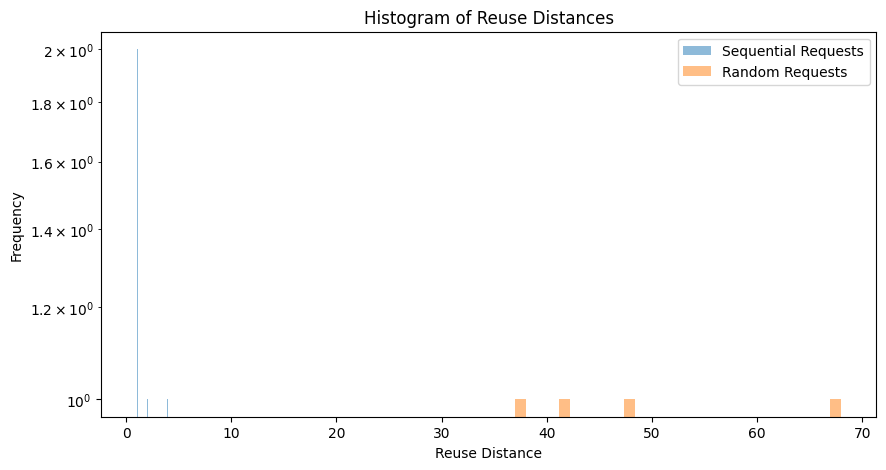

In [6]:

def compute_reuse_dist(requests: List[str]) -> List[int]:
    last = {}
    deltas = []
    for i, p in enumerate(requests):
        if p in last:
            deltas.append(i - last[p])
        last[p] = i
    return deltas

seq_requests = manager.sample_prompts(num_prompts=None, random_order=False)
rand_requests = manager.sample_prompts(num_prompts=None, random_order=True)

reuse_seq = compute_reuse_dist([p for p,_ in seq_requests])
reuse_rand = compute_reuse_dist([p for p,_ in rand_requests])

# Plot histogram of reuse distances (log scale)
plt.figure(figsize=(10, 5))
plt.hist(reuse_seq, bins=30, alpha=0.5, label='Sequential Requests', log=True)
plt.hist(reuse_rand, bins=30, alpha=0.5, label='Random Requests', log=True)
plt.title('Histogram of Reuse Distances')
plt.xlabel('Reuse Distance')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [7]:
import Dashboard as ds

dim = manager.emb_matrix.shape[1]
dashboard = ds.get_dashboard(manager, [LRUCache, LFUCache, TTLCache, RNDLRUCache, RNDTTLCache], num_requests=5000, dim=dim)
dashboard.servable()

BokehModel(combine_events=True, render_bundle={'docs_json': {'925ea062-2493-4cfd-abaa-5edcda1908c4': {'version…

### Chaching test

In [13]:
def faiss_search_similarity(
    index: faiss.IndexFlatIP,
    query: np.ndarray,
    topk: int = 10
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Esegue una ricerca di similarità usando FAISS.
    Ritorna le distanze e gli indici dei top-k risultati.
    La ricerca la fa su tutto il dataset indicizzato.
    - index: istanza di faiss.IndexFlatIP indicizzata
    - query: vettore di query (1D o 2D con una riga)
    - topk: numero di risultati da restituire
    """
    query = query.reshape(1, -1).astype(np.float32)
    distances, indices = index.search(query, topk)
    return distances[0], indices[0]

# Create FAISS index from the embedding matrix
dim = manager.emb_matrix.shape[1]
index = faiss.IndexFlatIP(dim)
index.add(manager.emb_matrix.astype(np.float32))

# Stampa le prime 10 similarità per un prompt casuale
prompt, emb = manager.sample_prompts(num_prompts=1, random_order=True)[0]
print(f"Prompt: {prompt}")
distances, indices = faiss_search_similarity(index, emb, topk=10)
print("Top-10 Similarities:")
for i, (dist, idx) in enumerate(zip(distances, indices)):
    if idx == -1:  # -1 indica che non ci sono risultati
        continue
    print(f"{i+1}: {manager.prompts_arr[idx]} (Similarity: {dist:.4f})")
print("Total prompts in index:", len(manager.prompts_arr))


Prompt: concept art of a silent hill monster. painted by edward hopper. 
Top-10 Similarities:
1: concept art of a silent hill monster. painted by edward hopper.  (Similarity: 1.0000)
2: concept art of a silent hill monster. painted by edward hopper.  (Similarity: 1.0000)
3: concept art of a silent hill monster. painted by edward hopper.  (Similarity: 1.0000)
4: a painting by edward hopper of psychedelic creatures that seem to communicate with the viewer  (Similarity: 0.7184)
5: a painting by edward hopper of a scene similar to the room  (Similarity: 0.6965)
6: a painting by edward hopper of scenes from the mad max movie universe.  (Similarity: 0.6883)
7: a painting by edward hopper of a bird with a staff  (Similarity: 0.6556)
8: a painting by edward hopper of the angel of death in new york city  (Similarity: 0.6311)
9: a painting by edward hopper of a woman in the streets of an apocalyptic city, surrounded by the darkness.  (Similarity: 0.6284)
10: a painting by edward hopper of a man 